In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,14,1,AC,SVE,VENTA COMPUTARIZADA,18110164,0,2018-11-03,POLLO SIN MENUDENCIA H-C,KG,0.0000,17.4440,209.3280,10.6800,10.6800,30.0758,FAENEADO
1,14,1,AC,SVE,VENTA COMPUTARIZADA,18110293,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,3.9160,46.9920,10.6800,10.6800,6.7515,FAENEADO
2,14,1,AC,SVE,VENTA COMPUTARIZADA,18110301,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.8654,22.4280,10.6800,10.6800,3.2227,FAENEADO
3,14,1,AC,SVE,VENTA COMPUTARIZADA,18110302,0,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,3.7683,45.2120,10.6800,10.6800,6.4961,FAENEADO
4,14,1,AC,SVE,VENTA COMPUTARIZADA,18110302,1,2018-11-04,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.9251,23.1400,10.6800,10.6800,3.3250,FAENEADO


In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [8]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame solo con las ventas del primer producto y un registro por día
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

# Imprimir el DataFrame df_top_1
print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'POLLO ESPECIAL', 'FILETE A GRANEL',
       'PIERNA MUSLO', 'PECHUGA', 'ALA PRIMERA', 'MUSLO', 'PIERNA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0  POLLO SIN MENUDENCIA H-C         1684
1           FILETE A GRANEL         1578
2            POLLO ESPECIAL         1552
3                    PIERNA         1504
4                     MUSLO         1397
5                   PECHUGA         1387
6              PIERNA MUSLO         1347
7                    CUELLO         1312
8               ALA PRIMERA         1253
9                    HIGADO         1188

DataFrame df_top_1:
     FechaMovimiento            NombreProducto  MontoBase   year
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280   2018
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700  18162
2         2018-11-05  POLLO SIN MENUDENCIA 

In [9]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [10]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (108283, 4)
sin noviembre  (1650, 4)
noviembre 2023  (30, 4)


In [11]:
#df_noviembre.head()
print(df_top_1)

     FechaMovimiento            NombreProducto  MontoBase   year
0         2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280   2018
1         2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700  18162
2         2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140   8072
3         2018-11-06  POLLO SIN MENUDENCIA H-C   704.3460  26234
4         2018-11-07  POLLO SIN MENUDENCIA H-C   257.6550   8072
...              ...                       ...        ...    ...
1675      2023-11-26  POLLO SIN MENUDENCIA H-C   890.0623  30345
1676      2023-11-27  POLLO SIN MENUDENCIA H-C  2294.0996  22253
1677      2023-11-28  POLLO SIN MENUDENCIA H-C  3332.3914  14161
1678      2023-11-29  POLLO SIN MENUDENCIA H-C  3563.8715  22253
1679      2023-11-30  POLLO SIN MENUDENCIA H-C  4296.0834  10115

[1680 rows x 4 columns]


In [12]:
df_noviembre.tail()

,FechaMovimiento,NombreProducto,MontoBase,year
1675,2023-11-26,POLLO SIN MENUDENCIA H-C,890.0623,30345
1676,2023-11-27,POLLO SIN MENUDENCIA H-C,2294.0996,22253
1677,2023-11-28,POLLO SIN MENUDENCIA H-C,3332.3914,14161
1678,2023-11-29,POLLO SIN MENUDENCIA H-C,3563.8715,22253
1679,2023-11-30,POLLO SIN MENUDENCIA H-C,4296.0834,10115


In [13]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [14]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  2476.3271
1      2023-11-02  5469.8955
2      2023-11-03  5823.3412
3      2023-11-04  5385.7282
4      2023-11-05  2729.9860
5      2023-11-06   996.0257
6      2023-11-07  1683.6664
7      2023-11-08  3041.4504
8      2023-11-09  5344.3076
9      2023-11-10  3196.6041
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(30, 2)


# PROPHET


### Preparado de los DataFrame

In [15]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase   year
1650      2023-11-01  POLLO SIN MENUDENCIA H-C  2476.3271  18207
1651      2023-11-02  POLLO SIN MENUDENCIA H-C  5469.8955  40460
1652      2023-11-03  POLLO SIN MENUDENCIA H-C  5823.3412  22253
1653      2023-11-04  POLLO SIN MENUDENCIA H-C  5385.7282  60690
1654      2023-11-05  POLLO SIN MENUDENCIA H-C  2729.9860  16184
1655      2023-11-06  POLLO SIN MENUDENCIA H-C   996.0257  28322
1656      2023-11-07  POLLO SIN MENUDENCIA H-C  1683.6664  44506
1657      2023-11-08  POLLO SIN MENUDENCIA H-C  3041.4504  22253
1658      2023-11-09  POLLO SIN MENUDENCIA H-C  5344.3076  54621
1659      2023-11-10  POLLO SIN MENUDENCIA H-C  3196.6041  32368
1660      2023-11-11  POLLO SIN MENUDENCIA H-C  1969.6056  38437
1661      2023-11-12  POLLO SIN MENUDENCIA H-C  4533.3930  14161
1662      2023-11-13  POLLO SIN MENUDENCIA H-C  3576.5896  32368
1663      2023-11-14  POLLO SIN MENUDENCIA H-C   605.9921  2

In [16]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
    FechaMovimiento            NombreProducto  MontoBase   year
662      2021-01-02  POLLO SIN MENUDENCIA H-C    59.2740   2021
663      2021-01-03  POLLO SIN MENUDENCIA H-C   642.4020  36378
664      2021-01-04  POLLO SIN MENUDENCIA H-C   724.1040  18189
665      2021-01-05  POLLO SIN MENUDENCIA H-C  1069.3350  46483
666      2021-01-06  POLLO SIN MENUDENCIA H-C  1014.0660  14147
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento     object
NombreProducto

<ipython-input-16-d6719813a328>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [17]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of              ds         y
0    2021-01-02   59.2740
1    2021-01-03  642.4020
2    2021-01-04  724.1040
3    2021-01-05 1069.3350
4    2021-01-06 1014.0660
..          ...       ...
983  2023-10-27 5064.5984
984  2023-10-28  987.0990
985  2023-10-29 2787.4978
986  2023-10-30 1635.4907
987  2023-10-31 1943.9291

[988 rows x 2 columns]>
(988, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7gdxztqh/8alb1hvs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7gdxztqh/49j0ot1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33890', 'data', 'file=/tmp/tmp7gdxztqh/8alb1hvs.json', 'init=/tmp/tmp7gdxztqh/49j0ot1b.json', 'output', 'file=/tmp/tmp7gdxztqh/prophet_model76kibpwr/prophet_model-20240302041215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7g

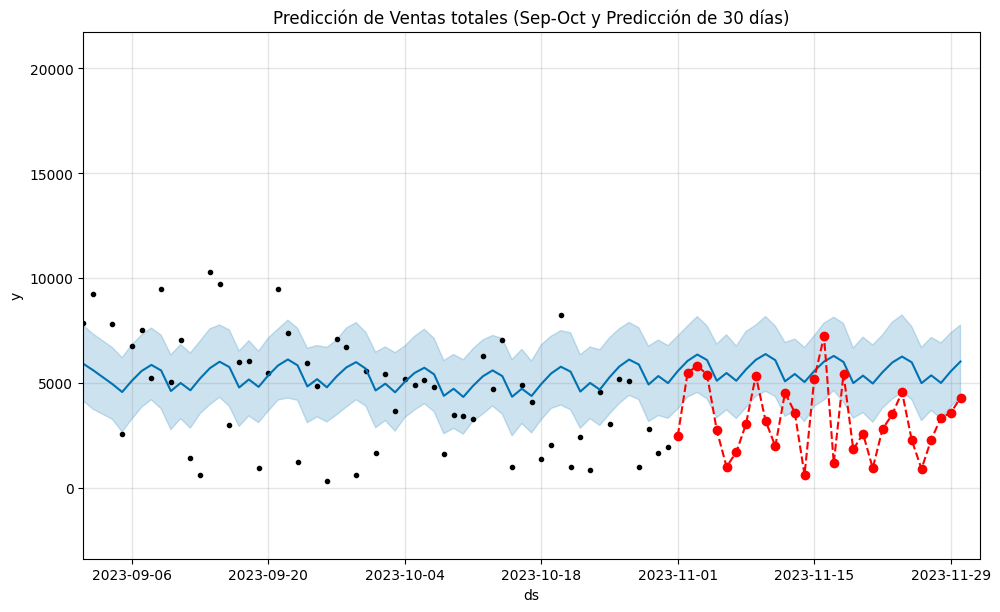

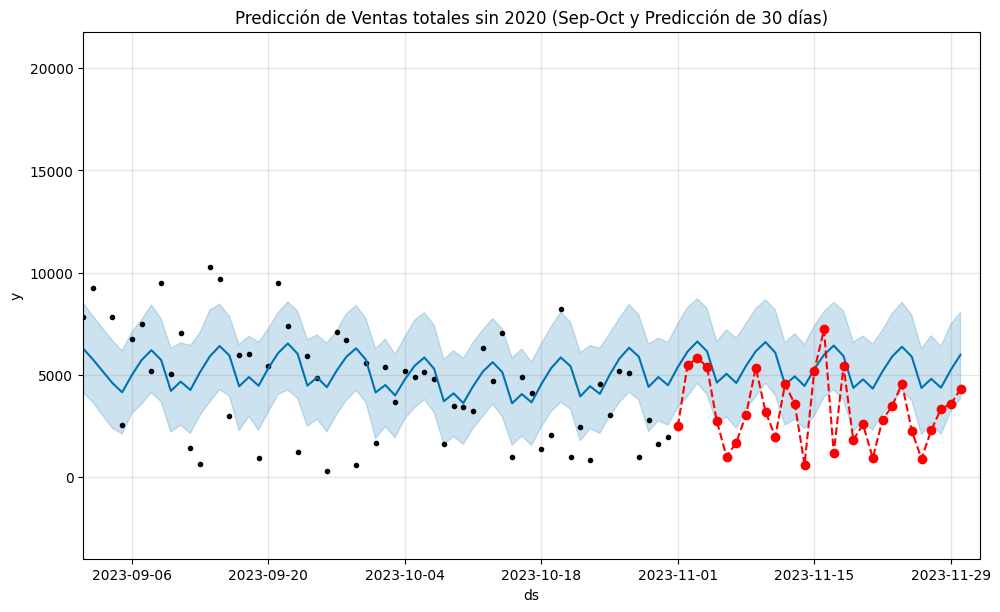

prediccion con todos los valores               ds      yhat
1650 2023-11-01 5558.8235
1651 2023-11-02 6044.7305
1652 2023-11-03 6348.5782
1653 2023-11-04 6084.7770
1654 2023-11-05 5097.9734
1655 2023-11-06 5467.3443
1656 2023-11-07 5098.6043
1657 2023-11-08 5639.5613
1658 2023-11-09 6094.6101
1659 2023-11-10 6369.6388
1660 2023-11-11 6079.6437
1661 2023-11-12 5069.7624
1662 2023-11-13 5419.5576
1663 2023-11-14 5035.0181
1664 2023-11-15 5564.1106
1665 2023-11-16 6011.2734
1666 2023-11-17 6282.3263
1667 2023-11-18 5992.0915
1668 2023-11-19 4985.4365
1669 2023-11-20 5341.5700
1670 2023-11-21 4966.0562
1671 2023-11-22 5506.3835
1672 2023-11-23 5966.4743
1673 2023-11-24 6251.6123
1674 2023-11-25 5976.0818
1675 2023-11-26 4984.2268
1676 2023-11-27 5354.7633
1677 2023-11-28 4992.8085
1678 2023-11-29 5545.4614
1679 2023-11-30 6016.3234
prediccion sin el 2020               ds      yhat
988  2023-11-01 5375.7182
989  2023-11-02 6135.3640
990  2023-11-03 6628.6163
991  2023-11-04 6148.4578
992  2

In [18]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION

evaluacion con todos los datos


In [19]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)



  FechaMovimiento  MontoBase
0      2023-11-01  2476.3271
1      2023-11-02  5469.8955
2      2023-11-03  5823.3412
3      2023-11-04  5385.7282
4      2023-11-05  2729.9860
5      2023-11-06   996.0257
6      2023-11-07  1683.6664
7      2023-11-08  3041.4504
8      2023-11-09  5344.3076
9      2023-11-10  3196.6041
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


### Revisar si noviembre no tiene espacios vacios


In [20]:
if len(df_noviembre_sumaT) < 30:
    # Crear un rango de fechas de noviembre
    fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30', freq='D')

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns]
    df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])

    # Crear un DataFrame con todas las fechas de noviembre
    todas_las_fechas = pd.DataFrame({'FechaMovimiento': fechas_noviembre})

    # Merge para obtener las fechas faltantes
    df_noviembre_sumaT = todas_las_fechas.merge(df_noviembre_sumaT, on='FechaMovimiento', how='left')

    # Llenar los valores faltantes con 0
    df_noviembre_sumaT['MontoBase'].fillna(0, inplace=True)

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns] sin tiempo
    df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'].dt.date)

    # Ordenar el DataFrame por fecha
    df_noviembre_sumaT.sort_values(by='FechaMovimiento', inplace=True)

# Asegurarse de que la longitud sea exactamente 30
assert len(df_noviembre_sumaT) == 30, "¡Error! El DataFrame no tiene 30 días."

# Imprimir el DataFrame resultante
print(df_noviembre_sumaT)

   FechaMovimiento  MontoBase
0       2023-11-01  2476.3271
1       2023-11-02  5469.8955
2       2023-11-03  5823.3412
3       2023-11-04  5385.7282
4       2023-11-05  2729.9860
5       2023-11-06   996.0257
6       2023-11-07  1683.6664
7       2023-11-08  3041.4504
8       2023-11-09  5344.3076
9       2023-11-10  3196.6041
10      2023-11-11  1969.6056
11      2023-11-12  4533.3930
12      2023-11-13  3576.5896
13      2023-11-14   605.9921
14      2023-11-15  5202.4149
15      2023-11-16  7216.1556
16      2023-11-17  1158.8779
17      2023-11-18  5431.1716
18      2023-11-19  1820.4060
19      2023-11-20  2569.6881
20      2023-11-21   928.5014
21      2023-11-22  2791.7253
22      2023-11-23  3489.6188
23      2023-11-24  4564.1603
24      2023-11-25  2263.6438
25      2023-11-26   890.0623
26      2023-11-27  2294.0996
27      2023-11-28  3332.3914
28      2023-11-29  3563.8715
29      2023-11-30  4296.0834


In [21]:
# print(df_noviembre_sumaT.dtypes)

copiar el dataframe de noviembre

In [22]:
df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

In [23]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  2476.3271       5558.8235
1       2023-11-02  5469.8955       6044.7305
2       2023-11-03  5823.3412       6348.5782
3       2023-11-04  5385.7282       6084.7770
4       2023-11-05  2729.9860       5097.9734
5       2023-11-06   996.0257       5467.3443
6       2023-11-07  1683.6664       5098.6043
7       2023-11-08  3041.4504       5639.5613
8       2023-11-09  5344.3076       6094.6101
9       2023-11-10  3196.6041       6369.6388
10      2023-11-11  1969.6056       6079.6437
11      2023-11-12  4533.3930       5069.7624
12      2023-11-13  3576.5896       5419.5576
13      2023-11-14   605.9921       5035.0181
14      2023-11-15  5202.4149       5564.1106
15      2023-11-16  7216.1556       6011.2734
16      2023-11-17  1158.8779       6282.3263
17      2023-11-18  5431.1716       5992.0915
18      2023-11-19  1820.4060       4985.4365
19      2023-11-20  2569.6881       5341.5700
20      2023-11-21   928.5014     

In [24]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 7782965.033100557
MAE is : 2430.320097570756
R2 is : -1.6991281112438132 %
------------------------------
MRSE is : 2789.7965934993463
MAPE is : 146.594152025374 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion sin 2020

In [25]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = pd.to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = pd.merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  2476.3271       5375.7182
1       2023-11-02  5469.8955       6135.3640
2       2023-11-03  5823.3412       6628.6163
3       2023-11-04  5385.7282       6148.4578
4       2023-11-05  2729.9860       4617.7042
5       2023-11-06   996.0257       5047.6671
6       2023-11-07  1683.6664       4598.5707
7       2023-11-08  3041.4504       5436.7291
8       2023-11-09  5344.3076       6149.8862
9       2023-11-10  3196.6041       6600.2425
10      2023-11-11  1969.6056       6081.6885
11      2023-11-12  4533.3930       4517.7918
12      2023-11-13  3576.5896       4920.4441
13      2023-11-14   605.9921       4450.2665
14      2023-11-15  5202.4149       5273.7818
15      2023-11-16  7216.1556       5978.7546
16      2023-11-17  1158.8779       6427.2235
17      2023-11-18  5431.1716       5912.7457
18      2023-11-19  1820.4060       4358.3992
19      2023-11-20  2569.6881       4775.4501


In [26]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 6506427.42390741
MAE is : 2189.369466286879
R2 is : -1.2564255510524864 %
------------------------------
MRSE is : 2550.7699668742007
MAPE is : 131.00143323676363 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




# LSTM


In [27]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [28]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

  FechaMovimiento            NombreProducto  MontoBase   year
0      2018-11-03  POLLO SIN MENUDENCIA H-C   209.3280   2018
1      2018-11-04  POLLO SIN MENUDENCIA H-C   456.5700  18162
2      2018-11-05  POLLO SIN MENUDENCIA H-C   313.8140   8072
3      2018-11-06  POLLO SIN MENUDENCIA H-C   704.3460  26234
4      2018-11-07  POLLO SIN MENUDENCIA H-C   257.6550   8072
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
(1650, 4)
---------------   PROPHET   ---------------
           ds        y
0  2018-11-03 209.3280
1  2018-11-04 456.5700
2  2018-11-05 313.8140
3  2018-11-06 704.3460
4  2018-11-07 257.6550
ds     object
y     float64
dtype: object
(1650, 2)


In [29]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

In [30]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-03        209.3280      5     11  2018
2018-11-04        456.5700      6     11  2018
2018-11-05        313.8140      0     11  2018
2018-11-06        704.3460      1     11  2018
2018-11-07        257.6550      2     11  2018
...                    ...    ...    ...   ...
2023-10-27       5064.5984      4     10  2023
2023-10-28        987.0990      5     10  2023
2023-10-29       2787.4978      6     10  2023
2023-10-30       1635.4907      0     10  2023
2023-10-31       1943.9291      1     10  2023

[1650 rows x 4 columns]


In [31]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-03        209.3280      5     11  2018
2018-11-04        456.5700      6     11  2018
2018-11-05        313.8140      0     11  2018
2018-11-06        704.3460      1     11  2018
2018-11-07        257.6550      2     11  2018
...                    ...    ...    ...   ...
2023-10-27       5064.5984      4     10  2023
2023-10-28        987.0990      5     10  2023
2023-10-29       2787.4978      6     10  2023
2023-10-30       1635.4907      0     10  2023
2023-10-31       1943.9291      1     10  2023

[1650 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds         y
0     2018-11-03  209.3280
1     2018-11-04  456.5700
2     2018-11-05  313.8140
3     2018-11-06  704.3460
4     2018-11-07  257.6550
...          ...       ...
1645  2023-10-27 5064.5984
1646  2023-10-28  987.0990
1647  2023-10-29 2787.4

In [32]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1650.0000,1650.0000,1650.0000,1650.0000
mean,2104.9685,2.8891,6.5685,2020.9121
std,2327.2438,1.9674,3.4855,1.4862
min,10.6800,0.0000,1.0000,2018.0000
25%,589.3802,1.0000,3.0000,2020.0000
50%,1175.1560,3.0000,7.0000,2021.0000
75%,2733.4125,5.0000,10.0000,2022.0000
max,20594.8136,6.0000,12.0000,2023.0000


In [33]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


dividir en entrenamiento y al final toda la prueba

In [34]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [35]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)  # Puedes ajustar el número de divisiones

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [36]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
41/41 - 2s - loss: 0.0041 - 2s/epoch - 46ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0027 - 426ms/epoch - 10ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0027 - 440ms/epoch - 11ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0026 - 484ms/epoch - 12ms/step
Epoch 5/50
41/41 - 1s - loss: 0.0026 - 530ms/epoch - 13ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0026 - 363ms/epoch - 9ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0025 - 325ms/epoch - 8ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0025 - 330ms/epoch - 8ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0026 - 334ms/epoch - 8ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0026 - 322ms/epoch - 8ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0026 - 326ms/epoch - 8ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0025 - 344ms/epoch - 8ms/step
Epoch 13/50
41/41 - 0s - loss: 0.0025 - 320ms/epoch - 8ms/step
Epoch 14/50
41/41 - 0s - loss: 0.0025 - 318ms/epoch - 8ms/step
Epoch 15/50
41/41 - 0s - loss: 0.0026 - 329ms/epoch - 8ms/step
Epoch 16/50
41/41 - 0s - loss: 0.0025 - 325ms/epoch - 8ms/step

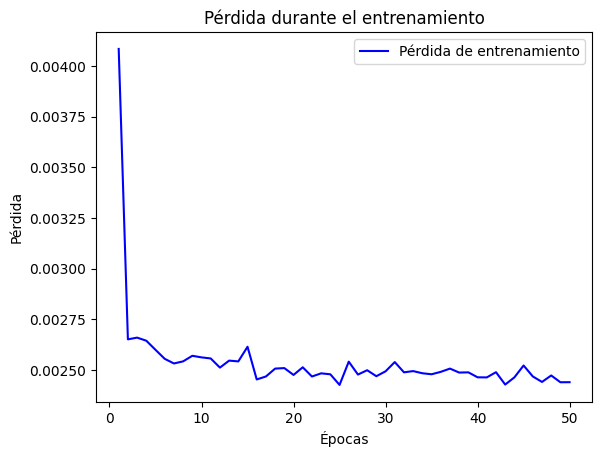

In [38]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 6635263.252445815


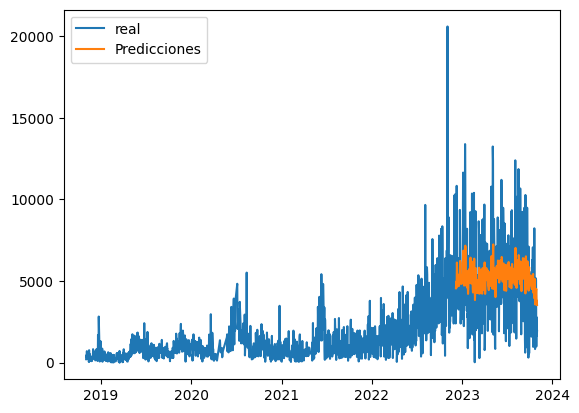

In [39]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size + seq_length : train_size + seq_length + len(predictions)], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [40]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1620, 30)
Forma de y: (1620, 1)


1/1 [==============================] - 0s 17ms/step


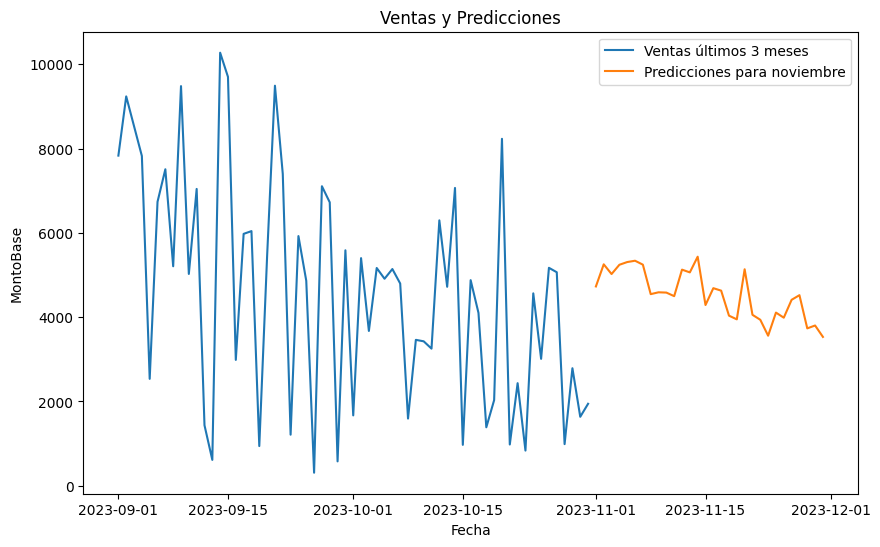

In [41]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

In [42]:
# last_3_months.shape
print(predictions_future.shape)

(30, 1)


### Evaluar

In [43]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  2476.3271       5558.8235    4727.8354
1       2023-11-02  5469.8955       6044.7305    5252.4155
2       2023-11-03  5823.3412       6348.5782    5021.9404
3       2023-11-04  5385.7282       6084.7770    5241.8354
4       2023-11-05  2729.9860       5097.9734    5306.3486
5       2023-11-06   996.0257       5467.3443    5337.5386
6       2023-11-07  1683.6664       5098.6043    5244.2437
7       2023-11-08  3041.4504       5639.5613    4545.0830
8       2023-11-09  5344.3076       6094.6101    4588.6392
9       2023-11-10  3196.6041       6369.6388    4581.9375
10      2023-11-11  1969.6056       6079.6437    4497.2417
11      2023-11-12  4533.3930       5069.7624    5126.0889
12      2023-11-13  3576.5896       5419.5576    5061.3252
13      2023-11-14   605.9921       5035.0181    5433.2900
14      2023-11-15  5202.4149       5564.1106    4287.0264
15      2023-11-16  7216.1556       6011.2734    4686.61

In [44]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 4856189.337530753
MAE is : 1788.0866381119793
R2 is : -0.6841238652244086 %
------------------------------
MRSE is : 2203.6763232223448
MAPE is : 117.62528858255973 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




## DESDE 2021

In [45]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = pd.to_datetime(df_lstm_desde_2021['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_desde_2021['DayOW'] = df_lstm_desde_2021.index.dayofweek
df_lstm_desde_2021['Month'] = df_lstm_desde_2021.index.month
df_lstm_desde_2021['Year'] = df_lstm_desde_2021.index.year

# Ordenar el DataFrame por la fecha
df_lstm_desde_2021.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_desde_2021)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_desde_2021['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2021-01-02         59.2740      5      1  2021
2021-01-03        642.4020      6      1  2021
2021-01-04        724.1040      0      1  2021
2021-01-05       1069.3350      1      1  2021
2021-01-06       1014.0660      2      1  2021
...                    ...    ...    ...   ...
2023-10-27       5064.5984      4     10  2023
2023-10-28        987.0990      5     10  2023
2023-10-29       2787.4978      6     10  2023
2023-10-30       1635.4907      0     10  2023
2023-10-31       1943.9291      1     10  2023

[988 rows x 4 columns]
Epoch 1/50
24/24 - 2s - loss: 0.0107 - 2s/epoch - 65ms/step
Epoch 2/50
24/24 - 0s - loss: 0.0071 - 194ms/epoch - 8ms/step
Epoch 3/50
24/24 - 0s - loss: 0.0067 - 177ms/epoch - 7ms/step
Epoch 4/50
24/24 - 0s - loss: 0.0067 - 182ms/epoch - 8ms/step
Epoch 5/50
24/24 - 0s - loss: 0.0066 - 170ms/epoch - 7ms/step
Epoch 6/50
24/24 - 0s - loss: 0.0067 - 196ms/epoch - 8ms/

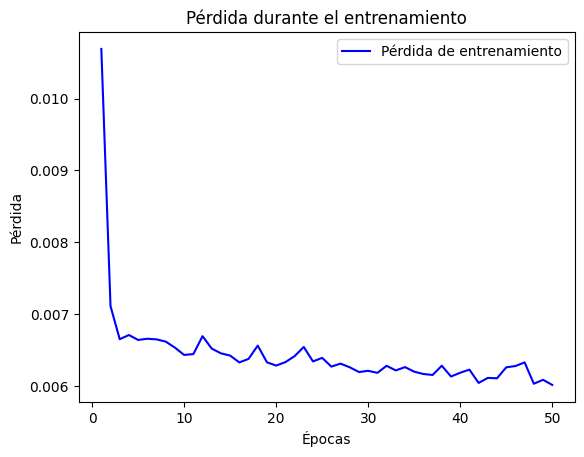

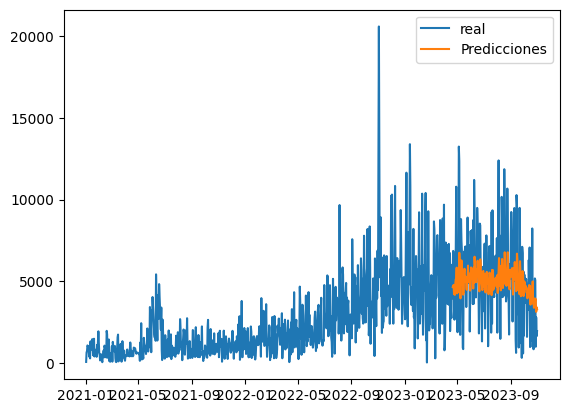

In [46]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_desde_2021['MontoBase'], label='real')
plt.plot(df_lstm_desde_2021.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (958, 30)
Forma de y: (958, 1)
1/1 [==============================] - 0s 289ms/step


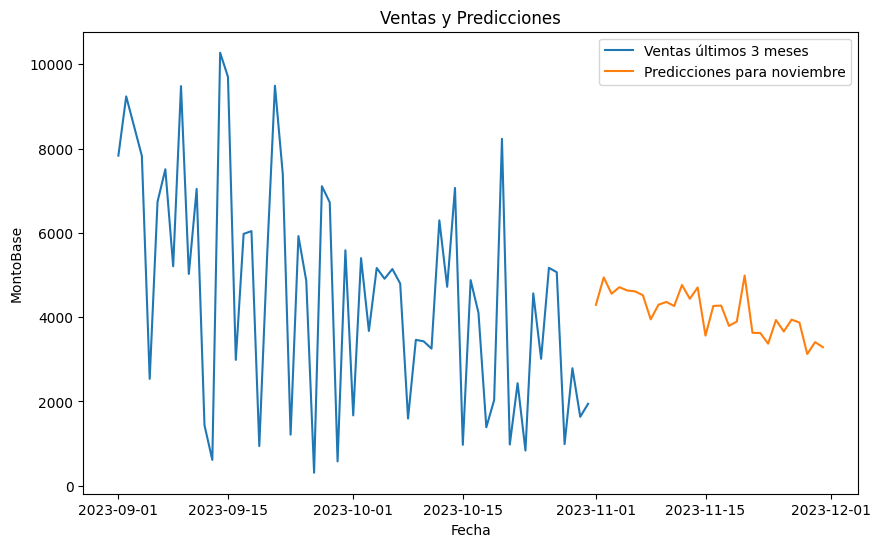

In [47]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_desde_2021 tiene la columna 'FechaMovimiento' como índice
df_lstm_desde_2021.index = pd.to_datetime(df_lstm_desde_2021.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [48]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  2476.3271       5558.8235    4727.8354
1       2023-11-02  5469.8955       6044.7305    5252.4155
2       2023-11-03  5823.3412       6348.5782    5021.9404
3       2023-11-04  5385.7282       6084.7770    5241.8354
4       2023-11-05  2729.9860       5097.9734    5306.3486
5       2023-11-06   996.0257       5467.3443    5337.5386
6       2023-11-07  1683.6664       5098.6043    5244.2437
7       2023-11-08  3041.4504       5639.5613    4545.0830
8       2023-11-09  5344.3076       6094.6101    4588.6392
9       2023-11-10  3196.6041       6369.6388    4581.9375
10      2023-11-11  1969.6056       6079.6437    4497.2417
11      2023-11-12  4533.3930       5069.7624    5126.0889
12      2023-11-13  3576.5896       5419.5576    5061.3252
13      2023-11-14   605.9921       5035.0181    5433.2900
14      2023-11-15  5202.4149       5564.1106    4287.0264
15      2023-11-16  7216.1556       6011.2734    4686.61

In [49]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 4856189.337530753
MAE is : 1788.0866381119793
R2 is : -0.6841238652244086 %
------------------------------
MRSE is : 2203.6763232223448
MAPE is : 117.62528858255973 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




# ARIMA

In [50]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [52]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-03,209.3280
1,2018-11-04,456.5700
2,2018-11-05,313.8140
3,2018-11-06,704.3460
4,2018-11-07,257.6550


## CON TODOS LOS AÑOS


In [53]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-03        209.3280
2018-11-04        456.5700
2018-11-05        313.8140
2018-11-06        704.3460
2018-11-07        257.6550
...                    ...
2023-10-27       5064.5984
2023-10-28        987.0990
2023-10-29       2787.4978
2023-10-30       1635.4907
2023-10-31       1943.9291

[1650 rows x 1 columns]>


In [54]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 2018-11-03 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1650 non-null   float64
dtypes: float64(1)
memory usage: 25.8+ KB


### Identificar si los datos son estacionarios o no


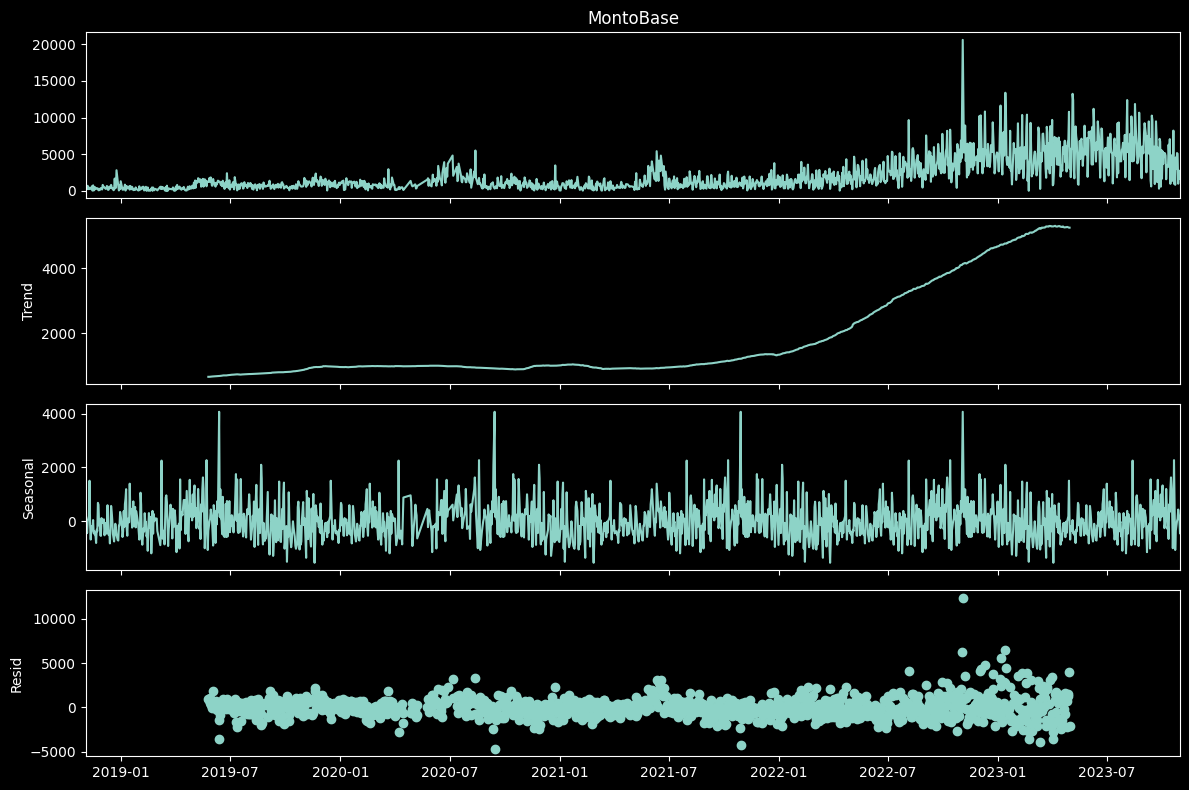

In [55]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [56]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
...,...
2023-10-27,5064.5984
2023-10-28,987.0990
2023-10-29,2787.4978


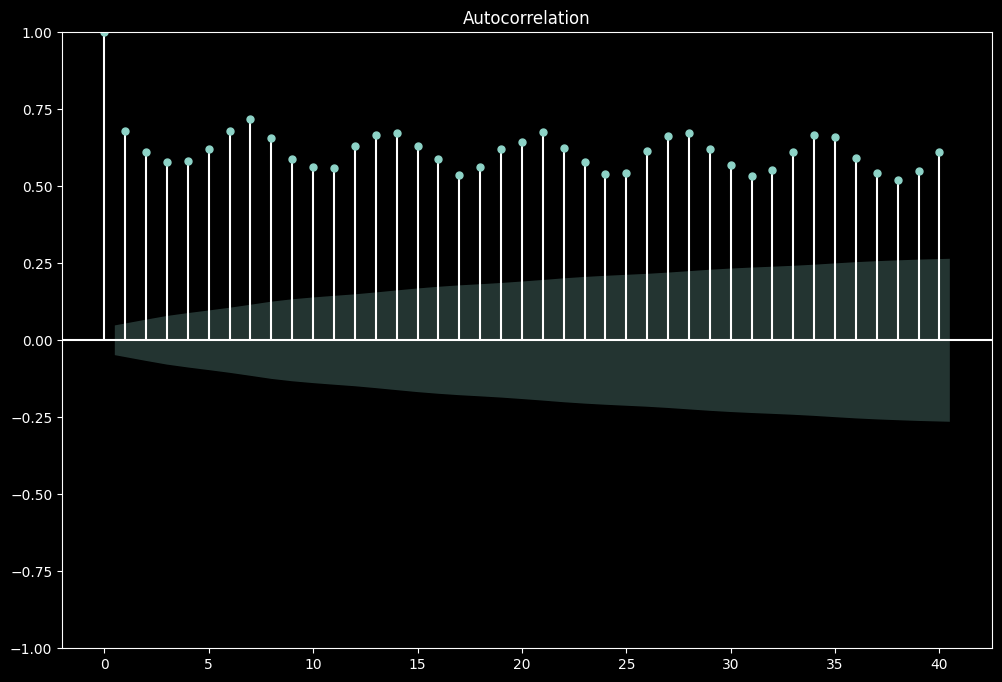

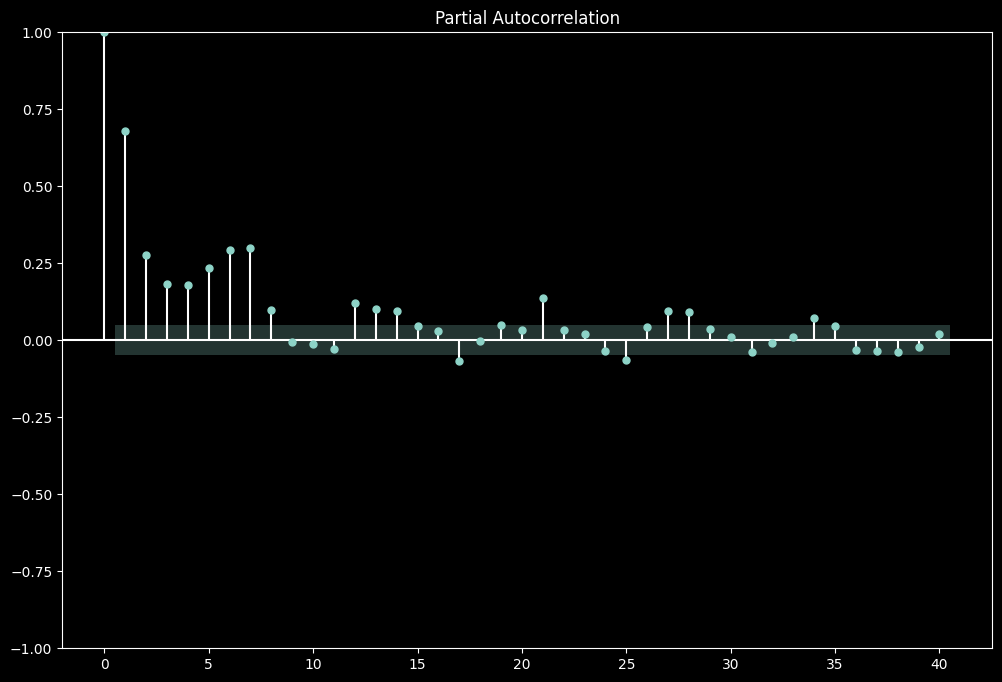

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

### prueba de Dickey-Fuller

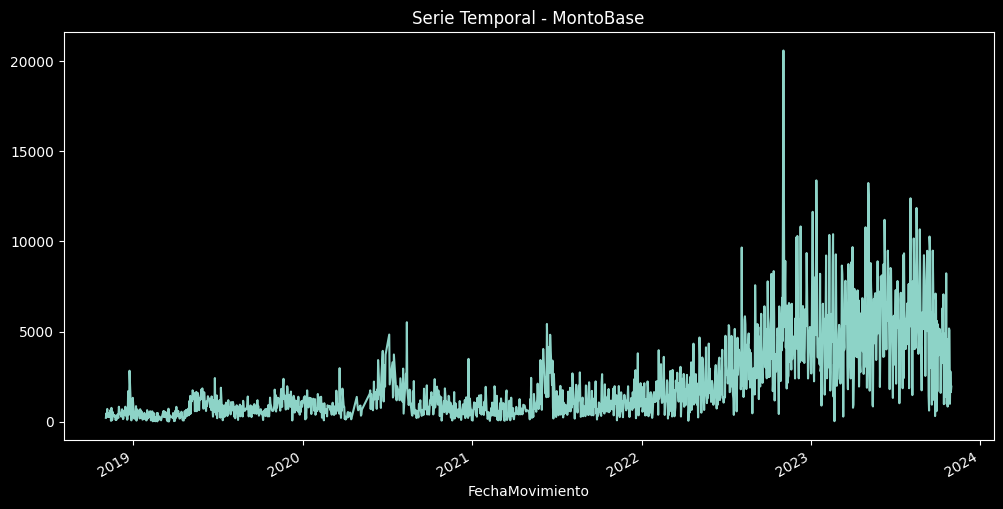

count    1650.0000
mean     2104.9685
std      2327.2438
min        10.6800
25%       589.3802
50%      1175.1560
75%      2733.4125
max     20594.8136
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -1.697604136509143
P-valor: 0.4323473186886986
Valores críticos: {'1%': -3.4343830457666806, '5%': -2.8633213561112156, '10%': -2.5677183557141645}


In [58]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
plt.title('Serie Temporal - MontoBase')
plt.show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [59]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [60]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -1.6976
p-value                                 0.4323
No Lags Used                           25.0000
Número de observaciones utilizadas   1624.0000
Critical Value (1%)                    -3.4344
Critical Value (5%)                    -2.8633
Critical Value (10%)                   -2.5677
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


### Dividir en train y test

In [61]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [62]:
train.shape, test.shape

((1619, 1), (31, 1))

### más pruebas


In [63]:
display(df_arima.head(10))
#df_arima = df_arima.set_index('FechaMovimiento')
df_arima = df_arima.asfreq('D')
display(df_arima.head(10))
#df_arima = df_arima.asfreq(None)

,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
2018-11-08,258.9010
2018-11-09,449.4500
2018-11-10,259.7910
2018-11-11,348.9690


,MontoBase
FechaMovimiento,
2018-11-03,209.3280
2018-11-04,456.5700
2018-11-05,313.8140
2018-11-06,704.3460
2018-11-07,257.6550
2018-11-08,258.9010
2018-11-09,449.4500
2018-11-10,259.7910
2018-11-11,348.9690


In [64]:
print(df_arima.isnull().sum())

MontoBase    174
dtype: int64


In [65]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -1.697604136509143, p-value: 0.4323473186886986
KPSS Statistic: 4.779534387700816, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -12.520504316833234, p-value: 2.5547031041196897e-23
KPSS Statistic: 0.051096846806105656, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -19.44426489521711, p-value: 0.0
KPSS Statistic: 0.02982617930633911, p-value: 0.1


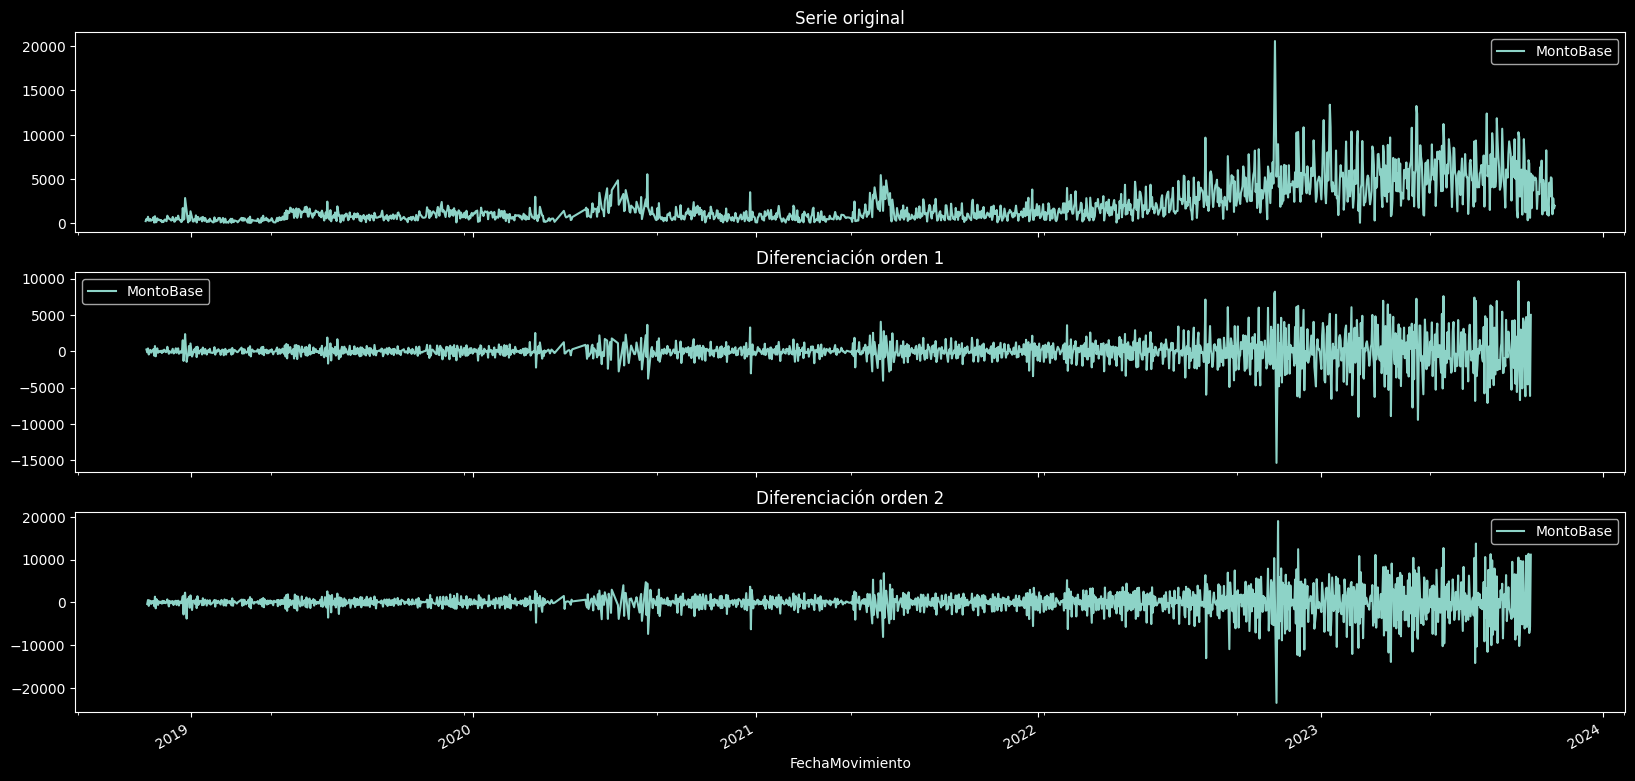

In [66]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


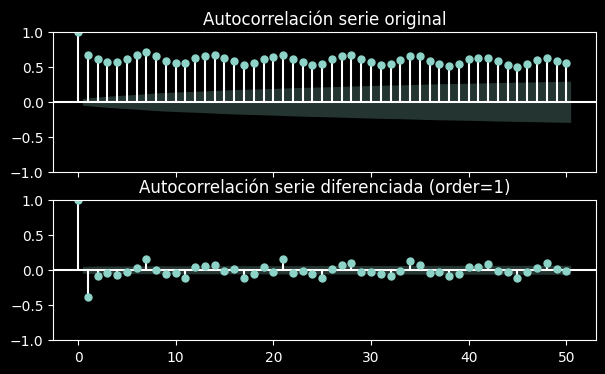

In [67]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

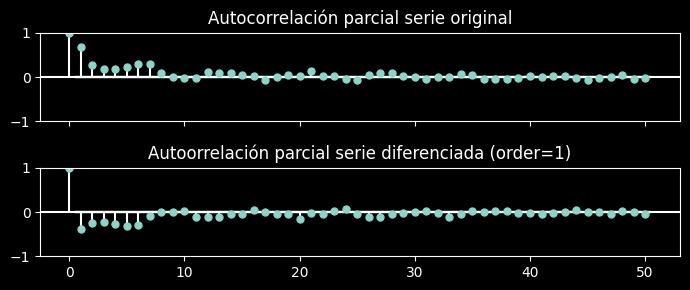

In [68]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [69]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [71]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -14.752061547525235, p-value: 2.4762106992047655e-27
KPSS Statistic: 0.020559426955176353, p-value: 0.1


### auto_arima


In [72]:
# Modelo Auto-Arima
from pmdarima import auto_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
#           max_p=5,max_d=2,max_q=5, start_P=0,
#           D=1, start_Q=0, max_P=3,max_D=2,
#           max_Q=3, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

In [74]:
# print(modelo_auto.summary())

### implementación del modelo

In [75]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-03        209.3280
2018-11-04        456.5700
2018-11-05        313.8140
2018-11-06        704.3460
2018-11-07        257.6550
...                    ...
2023-09-26        308.7321
2023-09-27       7105.2438
2023-09-28       6722.9176
2023-09-29        577.8058
2023-09-30       5585.3018

[1619 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-77-a09ff01a70ab>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


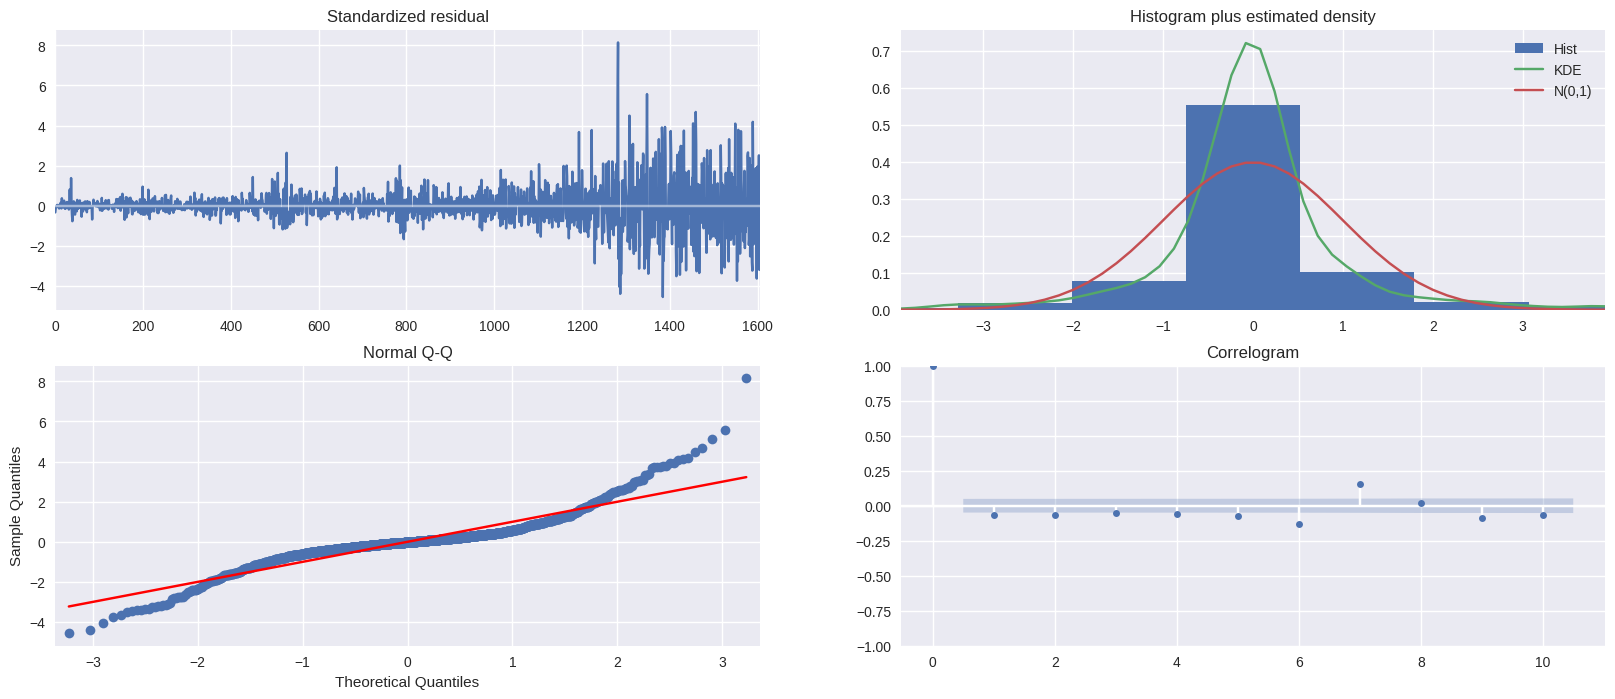

In [77]:
# plt.style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# plt.show()

In [76]:
# arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12)) # primerasucursal
# arima_model = SARIMAX(train["MontoBase"], order = (0,1,2), seasonal_order = (2,1,0,12)) # segundasucursal
arima_model = SARIMAX(train["MontoBase"], order = (5,1,0), seasonal_order = (3,1,0,12)) # tercerasucursal
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/ut

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                 1619
Model:             SARIMAX(5, 1, 0)x(3, 1, 0, 12)   Log Likelihood              -14126.797
Date:                            Sat, 02 Mar 2024   AIC                          28271.594
Time:                                    04:15:04   BIC                          28320.028
Sample:                                         0   HQIC                         28289.576
                                           - 1619                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7087      0.013    -55.032      0.000      -0.734      -0.683
ar.L2         -0.5942      0.016    -38.277      0.000      -0.625      -0.564
ar.L3         -0.4830      0.017    -28.329      0.000      -0.516      -0.450
ar.L4         -0.3729      0.016    -23.923      0.000      -0.403      -0.342
ar.L5         -0.2413      0.014    -17.125      0.000      -0.269      -0.214
ar.S.L12      -0.7228      0.017    -42.595      0.000      -0.756      -0.690
ar.S.L24      -0.6022      0.017    -34.454      0.000      -0.636      -0.568
ar.S.L36      -0.3852      0.015    -25.925      0.000      -0.414      -0.356
sigma2      2.548e+06   4.47e+04     56.951      0.000    2.46e+06    2.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.98   Jarque-Bera (JB):              3742.30
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              20.88   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [77]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1619   2404.2565
1620   3291.2453
1621   4375.1610
1622   3357.7156
1623   3995.6207
1624   4229.1808
1625   3127.8751
1626   3081.2460
1627   4400.6540
1628   3297.1356
1629    974.3532
1630   5485.7423
1631   3049.8041
1632   2213.7999
1633   3582.5569
1634   1272.7026
1635   2758.8179
1636   2164.2760
1637   1240.5164
1638   3816.3877
1639   5421.2206
1640   3062.5579
1641    281.7482
1642   3772.1490
1643   1906.9788
1644   1875.1450
1645   4908.1060
1646   1973.4647
1647   1895.0670
1648    622.2874
1649   -312.1963
Name: ARIMA_Predictions, dtype: float64

In [78]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   2404.2565
2023-10-02   3291.2453
2023-10-03   4375.1610
2023-10-04   3357.7156
2023-10-05   3995.6207
2023-10-06   4229.1808
2023-10-07   3127.8751
2023-10-08   3081.2460
2023-10-09   4400.6540
2023-10-10   3297.1356
2023-10-11    974.3532
2023-10-12   5485.7423
2023-10-13   3049.8041
2023-10-14   2213.7999
2023-10-15   3582.5569
2023-10-16   1272.7026
2023-10-17   2758.8179
2023-10-18   2164.2760
2023-10-19   1240.5164
2023-10-20   3816.3877
2023-10-21   5421.2206
2023-10-22   3062.5579
2023-10-23    281.7482
2023-10-24   3772.1490
2023-10-25   1906.9788
2023-10-26   1875.1450
2023-10-27   4908.1060
2023-10-28   1973.4647
2023-10-29   1895.0670
2023-10-30    622.2874
2023-10-31   -312.1963
Name: ARIMA_Predictions, dtype: float64


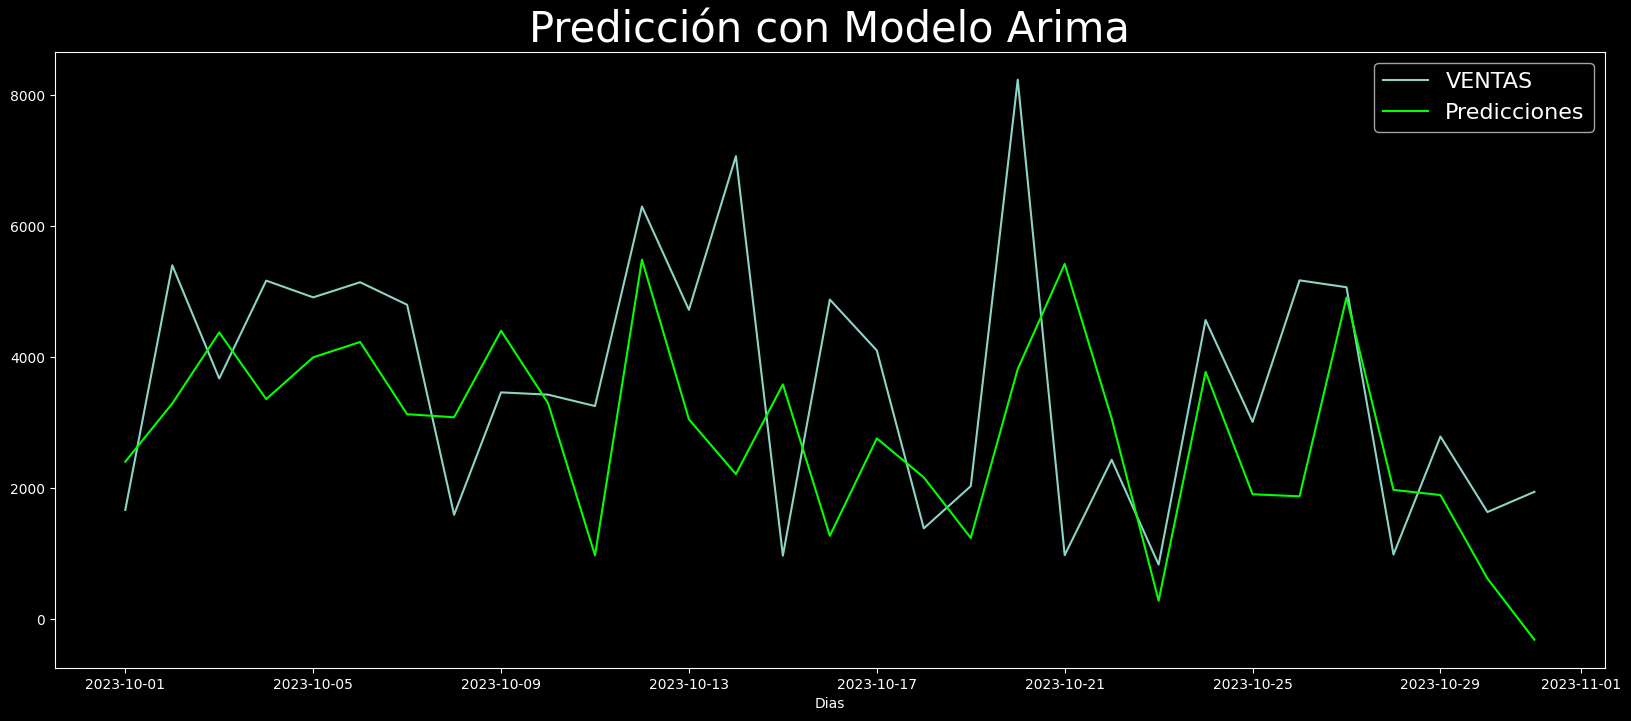

In [79]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [88]:
arima_pred2 = arima_result.predict(start = len(df_arima) ,end=len(df_arima)+29, typ="levels").rename("ARIMA Predictions")
arima_pred2
# start = 1699,end=1728 # en primera sucursal
# start = 1667,end=1697 # en segunda sucursal
# start = 1619,end=1649 # en tercera sucursal
# print(f'start   = {len(df_arima)}')
# print(f'end     = {len(df_arima)+30}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1650    3128.4064
1651    4986.4762
1652    1530.3144
1653     297.0475
1654    2920.8420
1655    -544.2272
1656    1275.4160
1657    4072.2895
1658    1953.6085
1659    -133.5448
1660    1307.4526
1661     289.5969
1662    -209.9154
1663    3402.8396
1664    1773.5812
1665   -1774.7427
1666    2281.3888
1667    -657.9160
1668       2.8073
1669    1858.4508
1670      24.0021
1671       4.2659
1672     211.0490
1673    -808.4685
1674       9.2163
1675    2091.1926
1676     285.7360
1677   -2344.6820
1678    1591.2271
1679    -984.5207
Name: ARIMA Predictions, dtype: float64

# pausa para ver la prediccion de noviembre


In [89]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  2476.3271       5558.8235    4727.8354
1      2023-11-02  5469.8955       6044.7305    5252.4155
2      2023-11-03  5823.3412       6348.5782    5021.9404
3      2023-11-04  5385.7282       6084.7770    5241.8354
4      2023-11-05  2729.9860       5097.9734    5306.3486
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  2476.3271       5558.8235    4727.8354
1      2023-11-02  5469.8955       6044.7305    5252.4155
2      2023-11-03  5823.3412       6348.5782    5021.9404
3      2023-11-04  5385.7282       6084.7770    5241.8354
4      2023-11-05  2729.9860       5097.9734    5306.3486


In [90]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

0     3128.4064
1     4986.4762
2     1530.3144
3      297.0475
4     2920.8420
5     -544.2272
6     1275.4160
7     4072.2895
8     1953.6085
9     -133.5448
10    1307.4526
11     289.5969
12    -209.9154
13    3402.8396
14    1773.5812
15   -1774.7427
16    2281.3888
17    -657.9160
18       2.8073
19    1858.4508
20      24.0021
21       4.2659
22     211.0490
23    -808.4685
24       9.2163
25    2091.1926
26     285.7360
27   -2344.6820
28    1591.2271
29    -984.5207
Name: ARIMA Predictions, dtype: float64


<ipython-input-91-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


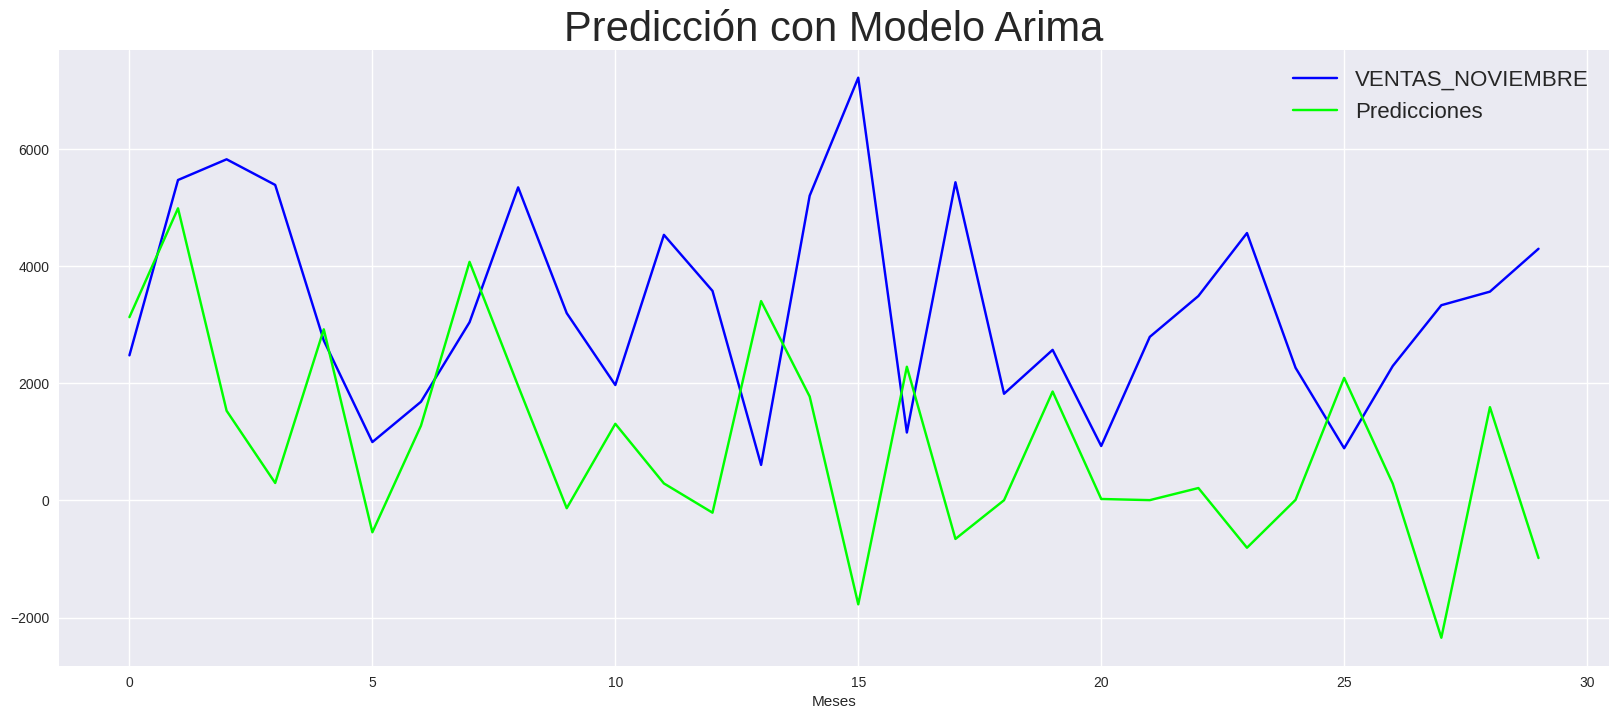

In [91]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [92]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  2476.3271       5558.8235    4727.8354     3128.4064
1       2023-11-02  5469.8955       6044.7305    5252.4155     4986.4762
2       2023-11-03  5823.3412       6348.5782    5021.9404     1530.3144
3       2023-11-04  5385.7282       6084.7770    5241.8354      297.0475
4       2023-11-05  2729.9860       5097.9734    5306.3486     2920.8420
5       2023-11-06   996.0257       5467.3443    5337.5386     -544.2272
6       2023-11-07  1683.6664       5098.6043    5244.2437     1275.4160
7       2023-11-08  3041.4504       5639.5613    4545.0830     4072.2895
8       2023-11-09  5344.3076       6094.6101    4588.6392     1953.6085
9       2023-11-10  3196.6041       6369.6388    4581.9375     -133.5448
10      2023-11-11  1969.6056       6079.6437    4497.2417     1307.4526
11      2023-11-12  4533.3930       5069.7624    5126.0889      289.5969
12      2023-11-13  3576.5896       5419.5576    50

In [93]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 12310752.298997281
MAE is : 2826.504042819868
R2 is : -3.2693623136509924 %
------------------------------
MRSE is : 3508.668165985105
MAPE is : 96.40154404628059 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




## Desde el 2021

In [94]:
df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-02         59.2740
2021-01-03        642.4020
2021-01-04        724.1040
2021-01-05       1069.3350
2021-01-06       1014.0660
...                    ...
2023-10-27       5064.5984
2023-10-28        987.0990
2023-10-29       2787.4978
2023-10-30       1635.4907
2023-10-31       1943.9291

[988 rows x 1 columns]>


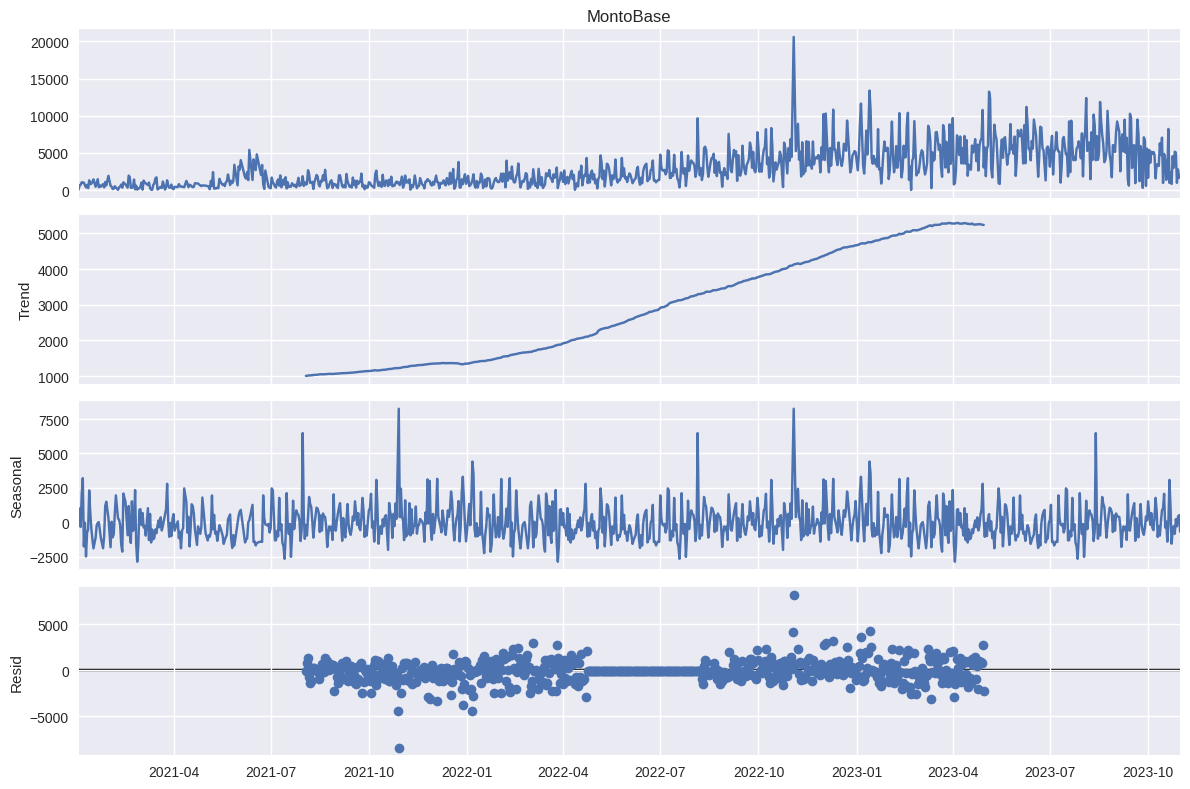

In [95]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [96]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 31)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

In [97]:
train_d21.shape, test_d21.shape

((957, 1), (31, 1))

In [98]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-02         59.2740
2021-01-03        642.4020
2021-01-04        724.1040
2021-01-05       1069.3350
2021-01-06       1014.0660
...                    ...
2023-09-26        308.7321
2023-09-27       7105.2438
2023-09-28       6722.9176
2023-09-29        577.8058
2023-09-30       5585.3018

[957 rows x 1 columns]


In [99]:
# posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
modelo_auto=auto_arima(train_d21,start_p=0,d=1,start_q=0,
          max_p=5,max_d=2,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=3,max_D=2,
          max_Q=3, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)
# ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17893.359, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17614.596, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17766.253, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=17465.369, Time=4.10 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=17301.811, Time=17.55 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=15.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.50 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=17475.117, Time=3.13 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=17212.794, Time=13.66 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=17387.590, Time=5.71 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=22.16 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.25 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=17161.422, Time=14.92 sec
 ARIMA(3,1,0)(2,1,0)[12]     

In [100]:
print(modelo_auto.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  957
Model:             SARIMAX(5, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -8528.216
Date:                            Sat, 02 Mar 2024   AIC                          17074.432
Time:                                    04:34:08   BIC                          17118.084
Sample:                                         0   HQIC                         17091.069
                                            - 957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7021      0.021    -33.832      0.000      -0.743      -0.661
ar.L2         -0.5930      0.025   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,2), seasonal_order = (2,1,0,12))
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,0), seasonal_order = (2,1,0,12))
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (5,1,0), seasonal_order = (3,1,0,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                  957
Model:             SARIMAX(5, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -8528.216
Date:                            Sat, 02 Mar 2024   AIC                          17074.432
Time:                                    04:35:54   BIC                          17118.084
Sample:                                         0   HQIC                         17091.069
                                            - 957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7021      0.021    -33.832      0.000      -0.743      -0.661
ar.L2         -0.5930      0.025    -23.770      0.000      -0.642      -0.544
ar.L3         -0.4818      0.028    -17.517      0.000      -0.536      -0.428
ar.L4         -0.3736      0.025    -14.898      0.000      -0.423      -0.324
ar.L5         -0.2448      0.023    -10.798      0.000      -0.289      -0.200
ar.S.L12      -0.7149      0.027    -26.161      0.000      -0.768      -0.661
ar.S.L24      -0.5973      0.028    -21.264      0.000      -0.652      -0.542
ar.S.L36      -0.3845      0.024    -16.084      0.000      -0.431      -0.338
sigma2       4.09e+06    1.2e+05     34.218      0.000    3.86e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):               602.25
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              13.04   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
arima_pred_d21 = arima_result_d21.predict(start = len(train_d21), end = len(df_arima_desde_2021)-2, typ="levels").rename("ARIMA_Predictions_since_2021")
arima_pred_d21
# o start = 965 , end = 994 en primerasucursal
# o start = 967 , end = 996 en segundasucursal
# o start = 957 , end = 986 en tercerasucursal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

957   2399.6326
958   3278.8937
959   4396.6495
960   3432.3133
961   3953.3205
962   4245.5212
963   3157.7613
964   3018.7240
965   4394.8753
966   3328.3272
967    955.4922
968   5484.2431
969   3040.8766
970   2204.4468
971   3563.6365
972   1290.1269
973   2752.2732
974   2184.4710
975   1264.3004
976   3785.3040
977   5397.6212
978   3071.2675
979    267.1174
980   3779.4487
981   1923.1061
982   1863.7027
983   4885.8332
984   1964.4036
985   1899.3642
986    619.8873
Name: ARIMA_Predictions_since_2021, dtype: float64

In [103]:
arima_pred_d21.index = df_noviembre_desde_2021.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_d21)

0    2399.6326
1    3278.8937
2    4396.6495
3    3432.3133
4    3953.3205
5    4245.5212
6    3157.7613
7    3018.7240
8    4394.8753
9    3328.3272
10    955.4922
11   5484.2431
12   3040.8766
13   2204.4468
14   3563.6365
15   1290.1269
16   2752.2732
17   2184.4710
18   1264.3004
19   3785.3040
20   5397.6212
21   3071.2675
22    267.1174
23   3779.4487
24   1923.1061
25   1863.7027
26   4885.8332
27   1964.4036
28   1899.3642
29    619.8873
Name: ARIMA_Predictions_since_2021, dtype: float64


<ipython-input-104-95a0eb4daed8>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  2476.3271       5375.7182    4291.2583
1      2023-11-02  5469.8955       6135.3640    4942.2056
2      2023-11-03  5823.3412       6628.6163    4555.2104
3      2023-11-04  5385.7282       6148.4578    4710.1909
4      2023-11-05  2729.9860       4617.7042    4631.5303
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  2476.3271       5375.7182    4291.2583
1      2023-11-02  5469.8955       6135.3640    4942.2056
2      2023-11-03  5823.3412       6628.6163    4555.2104
3      2023-11-04  5385.7282       6148.4578    4710.1909
4      2023-11-05  2729.9860       4617.7042    4631.5303


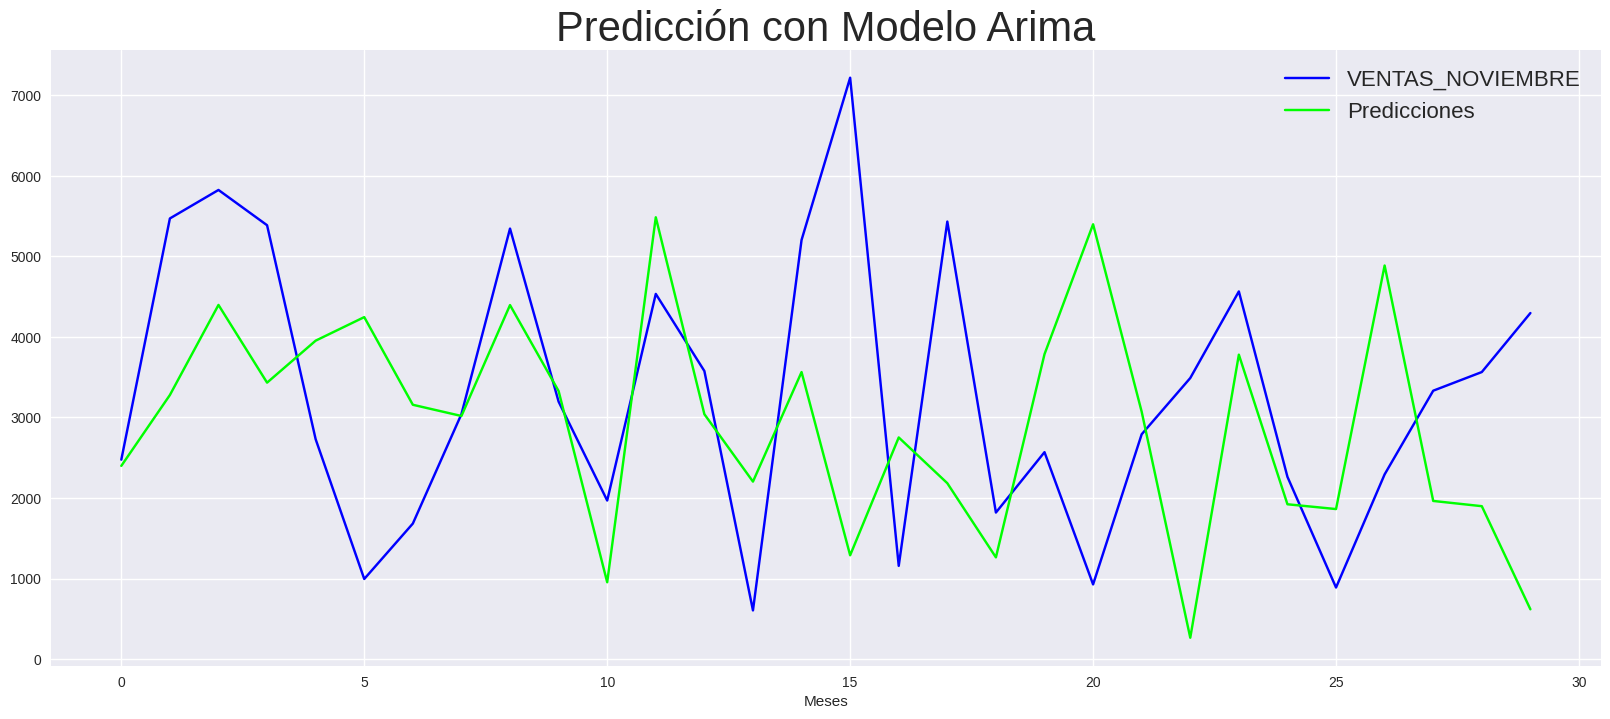

In [104]:
print(df_noviembre_desde_2021.head())
#df_noviembre_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_desde_2021.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_d21, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [105]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = arima_pred_d21

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  2476.3271       5375.7182    4291.2583     2399.6326
1       2023-11-02  5469.8955       6135.3640    4942.2056     3278.8937
2       2023-11-03  5823.3412       6628.6163    4555.2104     4396.6495
3       2023-11-04  5385.7282       6148.4578    4710.1909     3432.3133
4       2023-11-05  2729.9860       4617.7042    4631.5303     3953.3205
5       2023-11-06   996.0257       5047.6671    4610.9810     4245.5212
6       2023-11-07  1683.6664       4598.5707    4519.9316     3157.7613
7       2023-11-08  3041.4504       5436.7291    3947.4004     3018.7240
8       2023-11-09  5344.3076       6149.8862    4294.9062     4394.8753
9       2023-11-10  3196.6041       6600.2425    4360.0684     3328.3272
10      2023-11-11  1969.6056       6081.6885    4263.1860      955.4922
11      2023-11-12  4533.3930       4517.7918    4762.4595     5484.2431
12      2023-11-13  3576.5896       4920.4441    44

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 4674649.749175828
MAE is : 1678.161447043223
R2 is : -0.6211660330680941 %
------------------------------
MRSE is : 2162.0938344983615
MAPE is : 77.89146503306445 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# TODAS LAS EVALUACIONES

In [107]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:  
MSE is : 7782965.033100557
MAE is : 2430.320097570756
R2 is : -1.6991281112438132 %
------------------------------
MRSE is : 2789.7965934993463
MAPE is : 146.594152025374 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


---------- LSTM ----------
Evaluation metric results:  
MSE is : 4856189.337530753
MAE is : 1788.0866381119793
R2 is : -0.6841238652244086 %
------------------------------
MRSE is : 2203.6763232223448
MAPE is : 117.62528858255973 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


---------- ARIMA ----------
Evaluation metric results:  
MSE is : 12310752.298997281
MAE is : 2826.504042819868
R2 is : -3.2693623136509924 %
-------

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-108-b2c06a3cd456>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


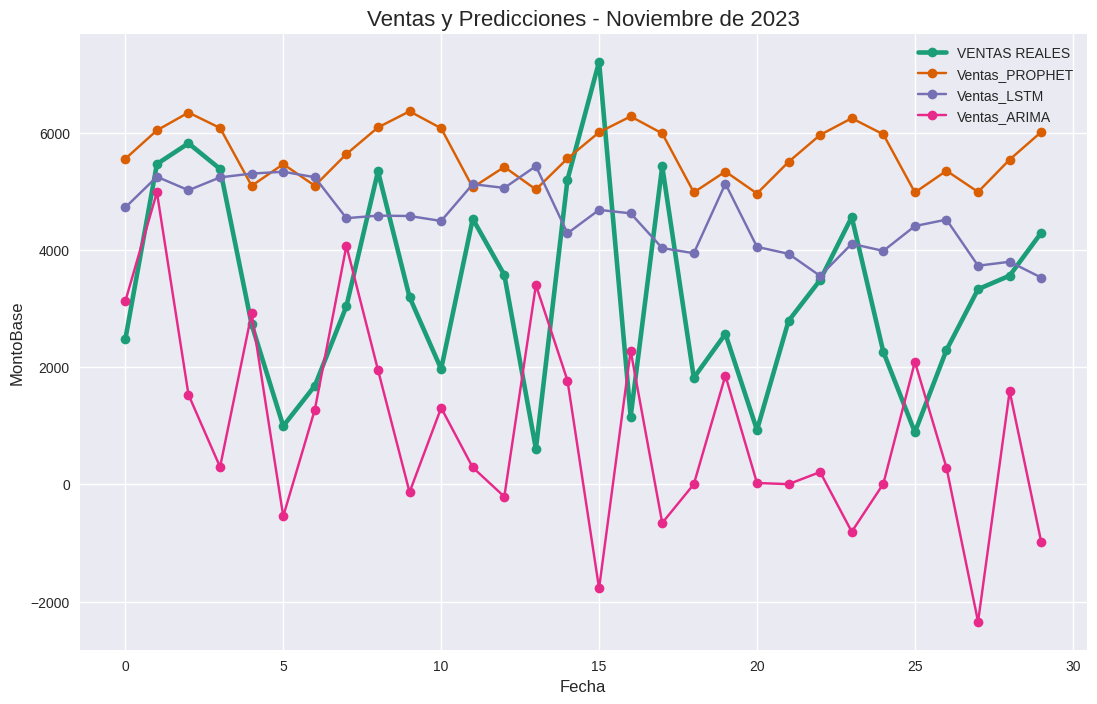

In [108]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-109-aba6b4d63878>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


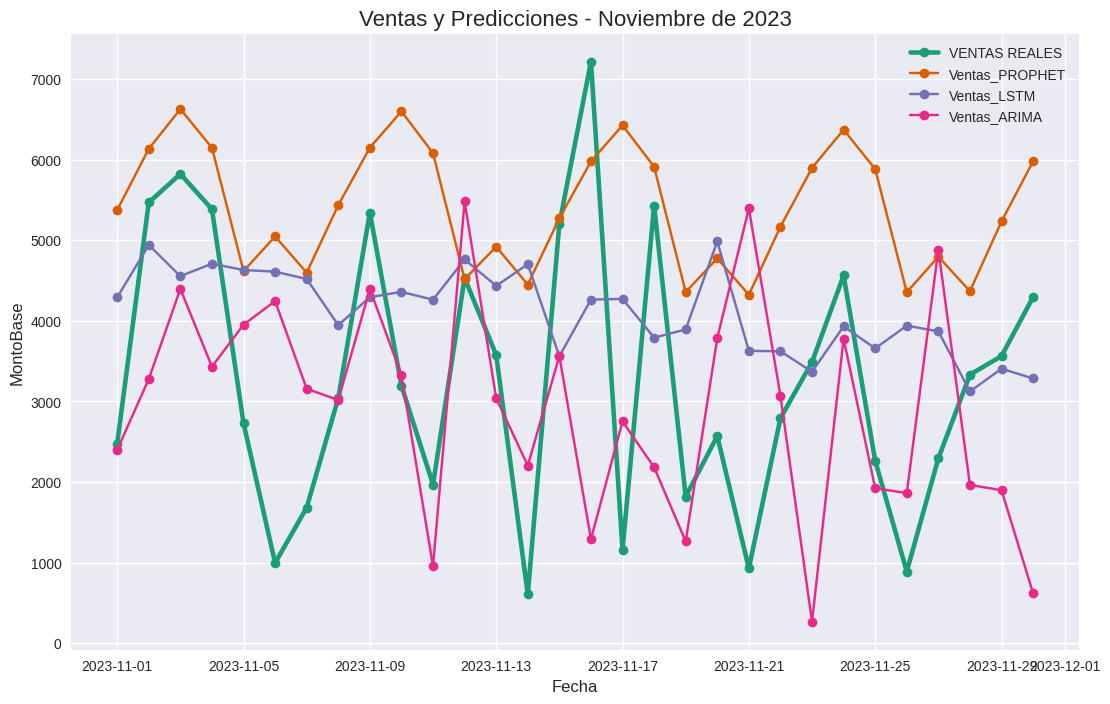

In [109]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()